# Capstone Project
### Pneumonia Detection
**Problem Statement:** Chest Radiograph is the most commonly used or performed diagnostic imaging Technology. Due to high volume of chest radiography, it could be very time consuming and intensive for the radiologists to review each image manually. As such, an automated solution is ideal to locate the position of inflammation in an image. By having such an automated pneumonia screening system, this can assist physicians to make better clinical decisions.

**Business Domain Value:** Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box. Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology). Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.

Details about the data and dataset files are given in below link, https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

**Purpose of this project:** Find out a patient with pnuemonia disease. There are some patients, which have some symptoms but not sure they might get affected by this diesea or not. This project also help to find out those patients, who have some symptoms and might get affected by this disease.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Colab Notebooks/Capstone Project'

/content/drive/MyDrive/Colab Notebooks/Capstone Project


In [3]:
!ls

'Capstone Project Pneumonia Detection Ronald.ipynb'
'GCP Credits Request Link - RSNA.txt'
 Pneumonia_Detection.ipynb
'Pneumonia Detection Ronald.ipynb'
'Pneumonia Detection with PPTs'
 stage_2_detailed_class_info.csv
 stage_2_sample_submission.csv
 stage_2_train_labels.csv


In [4]:
!pip3 install pydicom
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pydicom as dcm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
import gc
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 2.0 MB 5.3 MB/s 


In [5]:
#Unzip the .zip file

#from zipfile import ZipFile

#with ZipFile('/content/drive/MyDrive/Colab Notebooks/Capstone Project/rsna-pneumonia-detection-challenge.zip', 'r') as z:
  #z.extractall()

In [6]:
def read_csv(file_path):
  content = pd.read_csv(file_path)
  return content

project_path = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/'
labels = pd.read_csv("/".join((project_path, 'stage_2_train_labels.csv')))
class_desc = pd.read_csv("/".join((project_path, 'stage_2_detailed_class_info.csv')))


In [7]:
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [8]:
class_desc.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [9]:
def merge_data_frames(left_df,right_df,merge_on):
  df = pd.merge(left = left_df, right = right_df, how = 'left', on = merge_on)
  df = df.drop_duplicates()
  df.info()

merge_data_frames(class_desc,labels,'patientId')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37626
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   class      30227 non-null  object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [10]:
class_desc.dtypes

patientId    object
class        object
dtype: object

In [11]:
print("Number of unique patient IDs: ", class_desc['patientId'].nunique())

Number of unique patient IDs:  26684


In [12]:
class_desc['patientId'].value_counts().value_counts()

1    23286
2     3266
3      119
4       13
Name: patientId, dtype: int64

In [13]:
labels.shape

(30227, 6)

In [14]:
labels.dtypes

patientId     object
x            float64
y            float64
width        float64
height       float64
Target         int64
dtype: object

In [15]:
labels.isnull().values.any()

True

In [16]:
labels = labels.fillna(0)
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


**Database table Preprocessing**

In [17]:
def check_for_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)   # finding total number of null values
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) #percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # putting the above two together
    return missing_data


In [18]:
check_for_missing_data(labels)

,Total,Percent
patientId,0,0.0
x,0,0.0
y,0,0.0
width,0,0.0
height,0,0.0
Target,0,0.0


In [19]:
check_for_missing_data(class_desc)

,Total,Percent
patientId,0,0.0
class,0,0.0


Observation : No missing value found in the class_info table. All the target values are filled therefore there is no empty value, cell with NaN or empty cell in label_data are having no phenumonia so let's replace those value with 0.

In [20]:
labels.fillna(0, inplace=True)

In [21]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [22]:
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [23]:
labels[labels["Target"]==1].describe().T

,count,mean,std,min,25%,50%,75%,max
x,9555.0,394.047724,204.574172,2.0,207.0,324.0,594.0,835.0
y,9555.0,366.839560,148.940488,2.0,249.0,365.0,478.5,881.0
width,9555.0,218.471376,59.289475,40.0,177.0,217.0,259.0,528.0
height,9555.0,329.269702,157.750755,45.0,203.0,298.0,438.0,942.0
Target,9555.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [24]:
np.unique(class_desc["class"])  

array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
      dtype=object)

There are 3 classes - 


1.   Lung Opacity
2.   No Lung Opacity / Not Normal
3.   Normal



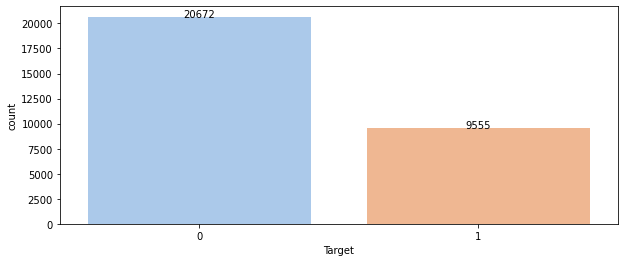

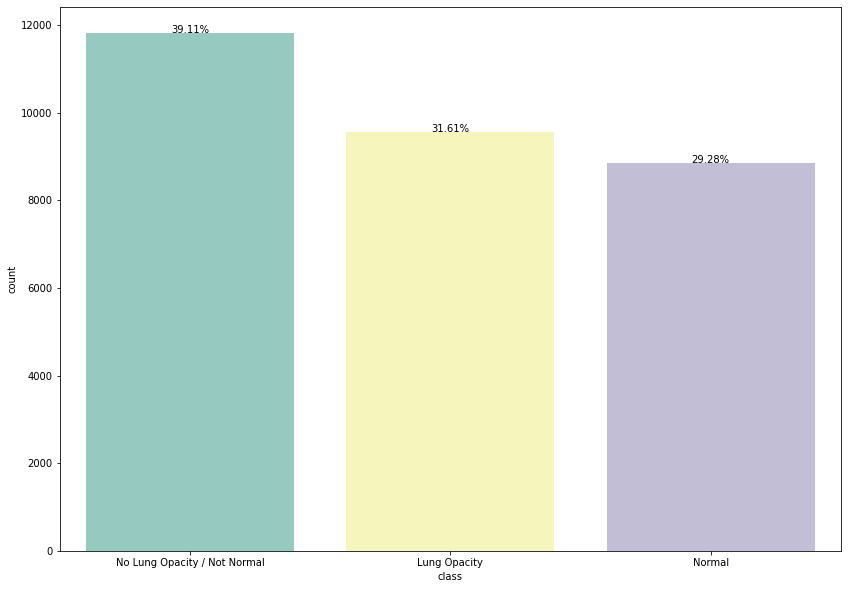

In [25]:
#Let us plot the distribution
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['lines.linewidth'] = 2

def countPlot(target="Target"):
    ax = sns.countplot(x=target, data=labels, palette="pastel")

    for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.400, p.get_height()+0.20), ha='center')

    plt.show()

countPlot("Target")

#To plot the 3 categories of the class
f, ax = plt.subplots(1,1, figsize=(14,10))
total = float(len(class_desc))
sns.countplot(class_desc['class'],order = class_desc['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 6,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [26]:
class_desc[class_desc["patientId"]=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal


In [27]:
labels[labels['patientId']=='0004cfab-14fd-4e49-80ba-63a80b6bddd6']

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0


No Lung Opacity / Not Normal has been classified as Target 0

In [28]:
class_desc[class_desc["patientId"]=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']


,patientId,class
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal


In [29]:
labels[labels['patientId']=='003d8fa0-6bf1-40ed-b54c-ac657f8495c5']

,patientId,x,y,width,height,Target
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0


Normal has been classified as 0 as well

In [30]:
class_desc[class_desc["patientId"]=='00436515-870c-4b36-a041-de91049b9ab4']

,patientId,class
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [31]:
labels[labels['patientId']=='00436515-870c-4b36-a041-de91049b9ab4']

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


Lung Opacity has been classified as 1 

In [32]:
!mkdir -p /content/sample_data/Stage2-data

os.chdir('/content/sample_data/Stage2-data/')

!pwd

!ls -lart '/content/sample_data/Stage2-data/'

/content/sample_data/Stage2-data
total 8
drwxr-xr-x 1 root root 4096 Mar  4 14:37 ..
drwxr-xr-x 2 root root 4096 Mar  4 14:37 .


In [33]:
from zipfile import ZipFile
import os

In [34]:
# Create a ZipFile Object and load sample.zip in it
def extract_zipFile(source_path,destination_path):
  try:
    with ZipFile(source_path, 'r') as zipObj:
      # Extract all the contents of zip file in destination_path
      zipObj.extractall(destination_path)
  except Exception as e:
    print(str(e))

In [41]:
#extracting train images
print("Extracting train images...")
extract_zipFile('/content/drive/MyDrive/stage_2_train_images.zip','/content/sample_data/Stage2-data/stage_2_train_images')

#extracting test images
print("Extracting test images...")
extract_zipFile('/content/drive/MyDrive/stage_2_test_images.zip','/content/sample_data/Stage2-data/stage_2_test_images')

Extracting train images...
Extracting test images...


In [42]:
# Images Example
train_images_folder = "/".join(('/content/sample_data/Stage2-data', "stage_2_train_images/stage_2_train_images/"))
test_images_folder = "/".join(('/content/sample_data/Stage2-data', "stage_2_test_images/stage_2_test_images/"))
def parse_dicom_images(image_dir):
  images_list = []
  images = os.listdir(image_dir)
  for image in images:
    image_file = os.path.join(image_dir, image)
    if os.path.isfile(image_file):
      images_list.append(image_file)
  return images_list

In [43]:
train_images = parse_dicom_images(train_images_folder)
test_images = parse_dicom_images(test_images_folder)
print('5 Training images', train_images[:5])
print('5 Test images', test_images[:5])

5 Training images ['/content/sample_data/Stage2-data/stage_2_train_images/stage_2_train_images/fddfb799-68be-418d-8caf-c99045137eb8.dcm', '/content/sample_data/Stage2-data/stage_2_train_images/stage_2_train_images/710fbf77-85ac-4974-9077-0d4d9fdb3e48.dcm', '/content/sample_data/Stage2-data/stage_2_train_images/stage_2_train_images/d01c47aa-347c-4919-a82e-b90b7d3b164f.dcm', '/content/sample_data/Stage2-data/stage_2_train_images/stage_2_train_images/f943bdb9-3c23-49f4-be0b-0f8bff48c7d3.dcm', '/content/sample_data/Stage2-data/stage_2_train_images/stage_2_train_images/7bb751e1-6d7d-4640-b48e-fb1ea39b0ad9.dcm']
5 Test images ['/content/sample_data/Stage2-data/stage_2_test_images/stage_2_test_images/248be5cb-5079-4ba7-b2ba-a0ff1062fff2.dcm', '/content/sample_data/Stage2-data/stage_2_test_images/stage_2_test_images/05b2cc6d-8a25-47c8-a191-bbaaadf0bf64.dcm', '/content/sample_data/Stage2-data/stage_2_test_images/stage_2_test_images/1a664216-c58a-4405-bb4b-7177d919e53d.dcm', '/content/sample_dat

In [44]:
column_list = ["Patient ID", "Patient Sex", "Patient's Age", "View Position", "Image Size"]
file_desc = pd.DataFrame(columns=column_list)

def add_images_to_df(df,images_list,count_limit=100):
    data = []
    count = 0
    for image_path in images_list:
      data_row_img_data = dcm.read_file(image_path)
      values = []
      count = count + 1
      values.append(data_row_img_data.PatientID)
      values.append(data_row_img_data.PatientSex)
      values.append(data_row_img_data.PatientAge)
      values.append(data_row_img_data.ViewPosition)
      values.append(f"{data_row_img_data.Rows}x{data_row_img_data.Columns}")
      zipped_val = dict(zip(column_list, values))
      df = df.append(zipped_val, True)
    print(df)
    return df

In [40]:
file_desc = add_images_to_df(file_desc, train_images,10000)

                                 Patient ID Patient Sex Patient's Age  \
0      fddfb799-68be-418d-8caf-c99045137eb8           M            46   
1      710fbf77-85ac-4974-9077-0d4d9fdb3e48           M            52   
2      d01c47aa-347c-4919-a82e-b90b7d3b164f           M            41   
3      f943bdb9-3c23-49f4-be0b-0f8bff48c7d3           F            52   
4      7bb751e1-6d7d-4640-b48e-fb1ea39b0ad9           M            79   
...                                     ...         ...           ...   
26679  54d69a5e-7f51-46fc-b141-0fd7e7086fae           M            50   
26680  817c90f1-a049-474e-bfd5-4e937e6fc234           M            68   
26681  a3b6bc70-8f6b-42b2-8a93-2b5676270ab6           F            34   
26682  8d837773-a674-4af2-b401-2b3216586c5e           M            45   
26683  9cc13090-1906-4f88-83e1-bde1c174bbec           F            68   

      View Position Image Size  
0                PA  1024x1024  
1                PA  1024x1024  
2                PA  102

In [45]:
file_desc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Patient ID     0 non-null      object
 1   Patient Sex    0 non-null      object
 2   Patient's Age  0 non-null      object
 3   View Position  0 non-null      object
 4   Image Size     0 non-null      object
dtypes: object(5)
memory usage: 0.0+ bytes


In [46]:
train_images_folder

'/content/sample_data/Stage2-data/stage_2_train_images/stage_2_train_images/'

In [47]:
dicom_file_path = os.path.join(train_images_folder + "05eebe4c-bca2-40d4-bb20-54fc60e2bcea.dcm")
file = dcm.read_file(dicom_file_path)
file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.15214.1517874384.336739
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.15214.1517874384.336739
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

Data Visualisation

In [48]:
gc.collect()

355

In [49]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join("",train_images_folder,patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target:'.format(
                data_row['patientId'],modality, age, sex, data_row['Target']))
        rows = labels[labels['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="red",alpha = 0.1))   
    plt.show()


<class 'pandas.core.frame.DataFrame'>
                               patientId      x      y  width  height  Target
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
8   00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9   00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1
14  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0       1


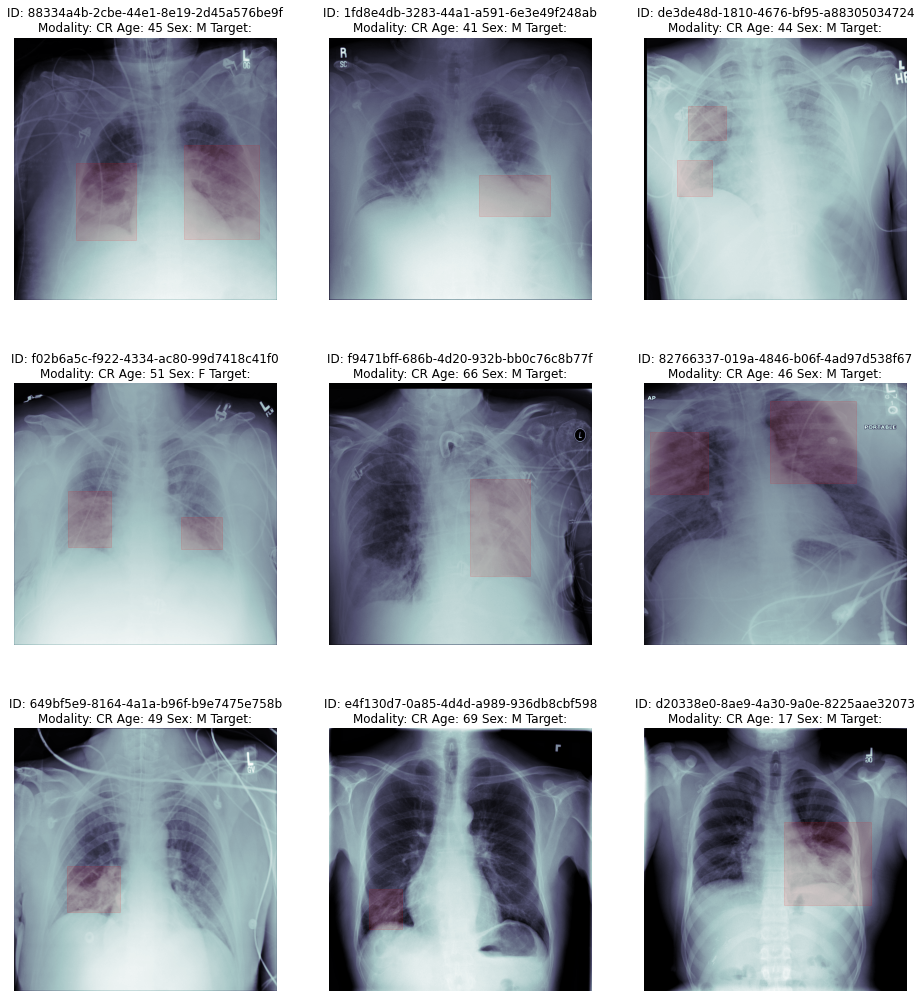

In [50]:
target = labels[labels['Target']==1]
print(type(target))
print(target.head())
#generating 9 row
show_dicom_images_with_boxes(labels[labels['Target']==1].sample(9))

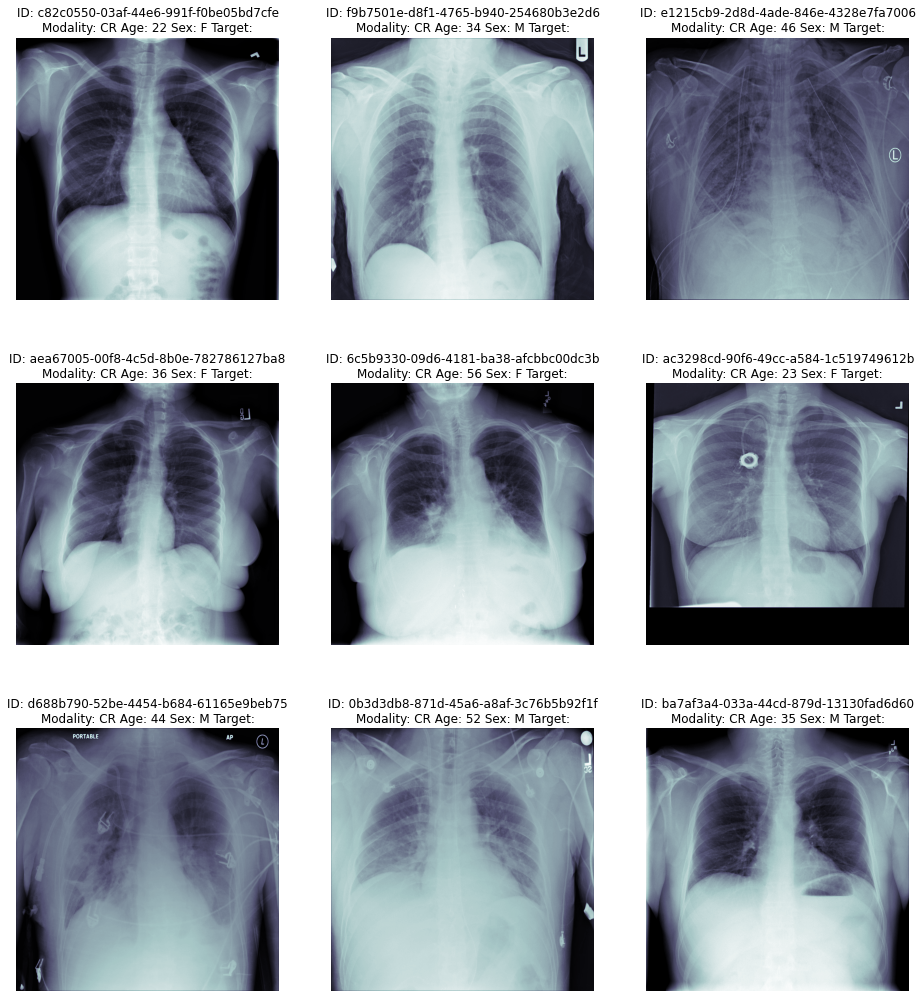

In [51]:
show_dicom_images_with_boxes(labels[labels['Target']==0].sample(9))

In [52]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(train_images_folder,patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: \nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()
    return data_row_img_data

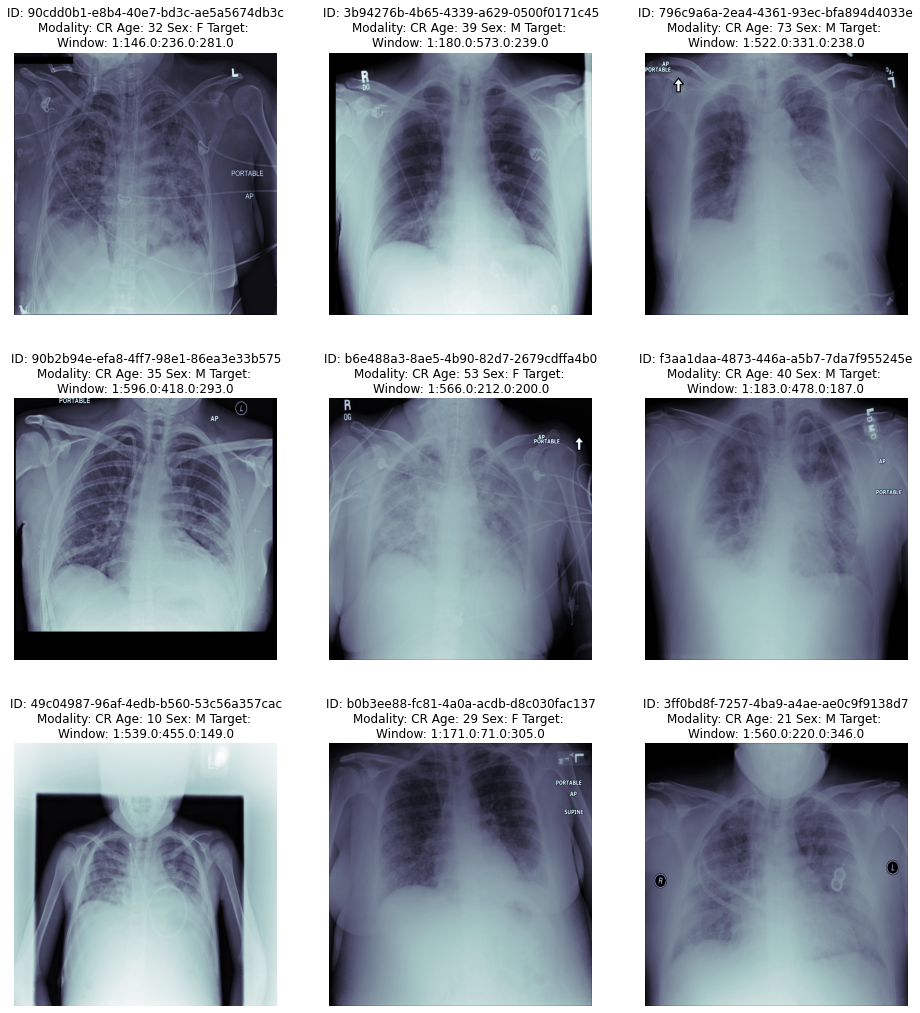

In [53]:
data_row_img_data = show_dicom_images(labels[labels['Target']==1].sample(9))

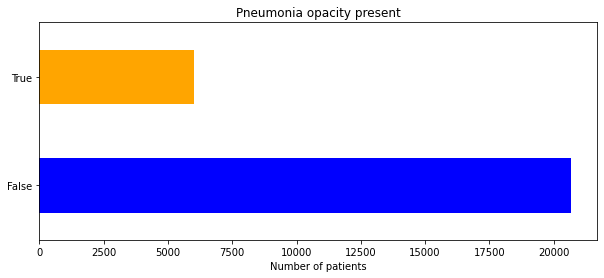

In [54]:
boxes_per_patient = labels.groupby('patientId')['Target'].sum()

ax = (boxes_per_patient > 0).value_counts().plot.barh(color=['blue','orange'])
_ = ax.set_title('Pneumonia opacity present')
_ = ax.set_xlabel('Number of patients')
_ = ax.xaxis.set_tick_params(rotation=0)

In [55]:
import seaborn as sns
sns.set(color_codes=True)

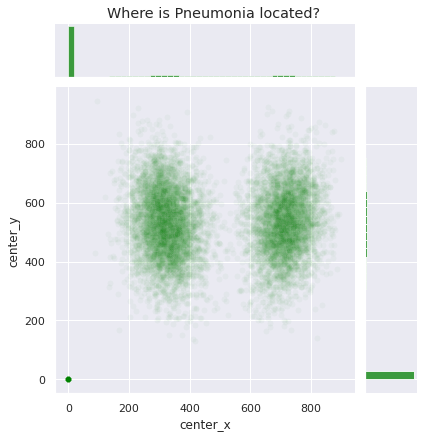

In [56]:
centers = (labels.dropna(subset=['x'])
           .assign(center_x=labels.x + labels.width / 2, 
                   center_y=labels.y + labels.height / 2))
ax = sns.jointplot("center_x", "center_y", data=centers, height=6, alpha=0.03, color="green")
_ = ax.fig.suptitle("Where is Pneumonia located?", y=1.01)

In [57]:
labels['aspect_ratio'] = (labels['width'] / labels['height'])
labels['area'] = labels['width'] * labels['height']

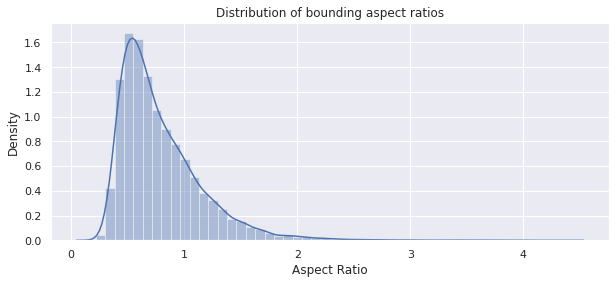

In [58]:
ax = sns.distplot(labels['aspect_ratio'].dropna(), norm_hist=True)
_ = ax.set_title("Distribution of bounding aspect ratios")
_ = ax.set_xlabel("Aspect Ratio")

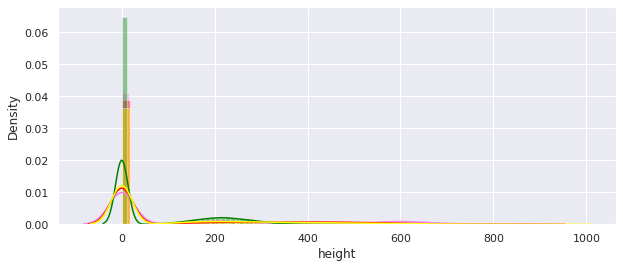

In [59]:
sns.distplot(labels['x'],kde=True,bins=50, color="violet")
sns.distplot(labels['y'],kde=True,bins=50, color="red")
sns.distplot(labels['width'],kde=True,bins=50, color="green")
sns.distplot(labels['height'],kde=True,bins=50, color="yellow")


In [60]:
import multiprocessing

def get_info(patientId, root_dir=train_images_folder):
    file_name = os.path.join(root_dir, f'{patientId}.dcm')
    dicom_data = dcm.read_file(file_name)
    return {'age': dicom_data.PatientAge, 
            'gender': dicom_data.PatientSex,
            'view_position': dicom_data.ViewPosition,
            'id': os.path.basename(file_name).split('.')[0],
            'pixel_spacing': float(dicom_data.PixelSpacing[0]),
            'mean_black_pixels': np.mean(dicom_data.pixel_array == 0)}

patient_ids = list(labels.patientId.unique())
with multiprocessing.Pool(4) as pool:
    result = pool.map(get_info, patient_ids)
    
demo = pd.DataFrame(result)
demo['age'] = demo['age'].astype(int)
demo['gender'] = demo['gender'].astype('category')
demo['view_position'] = demo['view_position'].astype('category')

labels = (labels.merge(demo, left_on='patientId', right_on='id', how='left').drop(columns='id'))

In [61]:
labels[2:5]

,patientId,x,y,width,height,Target,aspect_ratio,area,age,gender,view_position,pixel_spacing,mean_black_pixels
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,NaN,0.0,19,M,AP,0.168,0.000000
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,NaN,0.0,28,M,PA,0.143,0.011372
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,0.562005,80727.0,32,F,AP,0.139,0.002634


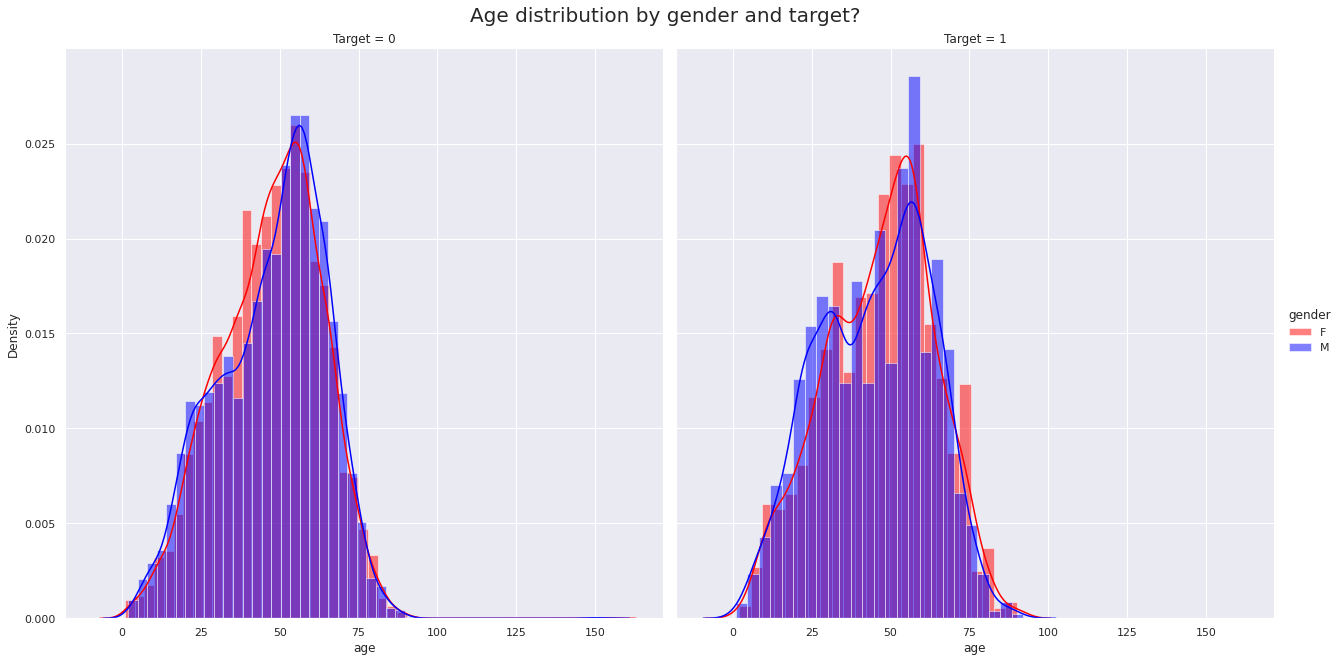

In [62]:
import seaborn as sns
sns.set(color_codes=True)

g = sns.FacetGrid(col='Target', hue='gender', 
                  data=labels.drop_duplicates(subset=['patientId']), 
                  height=9, palette=dict(F="red", M="blue"))
_ = g.map(sns.distplot, 'age', hist_kws={'alpha': 0.5}).add_legend()
_ = g.fig.suptitle("Age distribution by gender and target?", y=1.02, fontsize=20)

**VGG-16**

In [63]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import pydicom as dcm
import pandas as pd
import pickle

In [64]:
data = []
bbox_coords = []
target_label = []
img_paths = []

In [65]:
label_data=labels[0:10000]

In [66]:
label_data[2:5]

,patientId,x,y,width,height,Target,aspect_ratio,area,age,gender,view_position,pixel_spacing,mean_black_pixels
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,NaN,0.0,19,M,AP,0.168,0.000000
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,NaN,0.0,28,M,PA,0.143,0.011372
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,0.562005,80727.0,32,F,AP,0.139,0.002634


In [67]:
for i in range(len(label_data)):
  filename=label_data.iloc[i,0]
  startX = label_data.iloc[i,1]
  startY = label_data.iloc[i,2]
  endX = label_data.iloc[i,3]
  endY = label_data.iloc[i,4]
  label= label_data.iloc[i,5]
  img_path = os.path.join('/content/sample_data/Stage2-data/stage_2_train_images/stage_2_train_images/', filename+".dcm")##Change the path to your directory where images are located
  img = dcm.dcmread(img_path).pixel_array

  h = float(img.shape[0])
  w = float(img.shape[1])

  # Scale bounding box coordinates relative to the image
  startX = float(startX)/w
  startY = float(startY)/h
  endX = float(endX)/w
  endY = float(endY)/h
  img = cv2.resize(img,(224,224))
  data.append(img)
  bbox_coords.append((startX,startY,endX,endY))
  target_label.append(label)
  img_paths.append(img_path)

In [68]:
#Scaling data and bbox
data = np.array(data, dtype="float32") / 255.0
target_label = np.array(target_label)
bbox_coords = np.array(bbox_coords, dtype="float32")

In [69]:
# Saving data to disk
with open(os.path.join("/content/drive/MyDrive/","data.pkl"), 'wb') as f:
    pickle.dump(data, f, protocol=4)

with open(os.path.join("/content/drive/MyDrive/","target_label.pkl"),'wb') as f:
    pickle.dump(target_label, f, protocol=4)

with open(os.path.join("/content/drive/MyDrive/","bbox_coords.pkl"),'wb') as f:
    pickle.dump(bbox_coords, f, protocol=4)

with open(os.path.join("/content/drive/MyDrive/","img_paths.pkl"),'wb') as f:
    pickle.dump(img_paths, f, protocol=4)

In [70]:
# Fine tuning VGG16
image_input = Input(shape=(224,224,1))
image_input = Concatenate()([image_input,image_input,image_input])
vgg_model = VGG16(weights="imagenet", include_top=False,input_tensor= image_input)
vgg_model.trainable = False

basemodel_output = vgg_model.output
flatten = Flatten()(basemodel_output)

# New FC layers for Regression
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="BBOX_Head")(bboxHead)

# New FC layers for Classification
classHead = Dense(512, activation="relu")(flatten)
classHead = Dense(512, activation="relu")(classHead)
classHead = Dense(128, activation="relu")(classHead)
classHead = Dense(1, activation="sigmoid", name="Classification_Head")(classHead)

58900480/58889256 [==============================] - 1s 0us/step


In [71]:
model = Model(inputs=vgg_model.input, outputs=(classHead, bboxHead))

In [72]:
opt = SGD(lr=0.01)
losses = {
    "Classification_Head": "categorical_crossentropy",
    "BBOX_Head": "mean_squared_error"
}

loss_weights = {
    "Classification_Head": 1.0,
    "BBOX_Head": 1.0
}

In [73]:
model.compile(loss=losses, optimizer=opt, loss_weights= loss_weights, metrics=["accuracy"])

In [74]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 224, 224, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['concatenate[0][0]']        

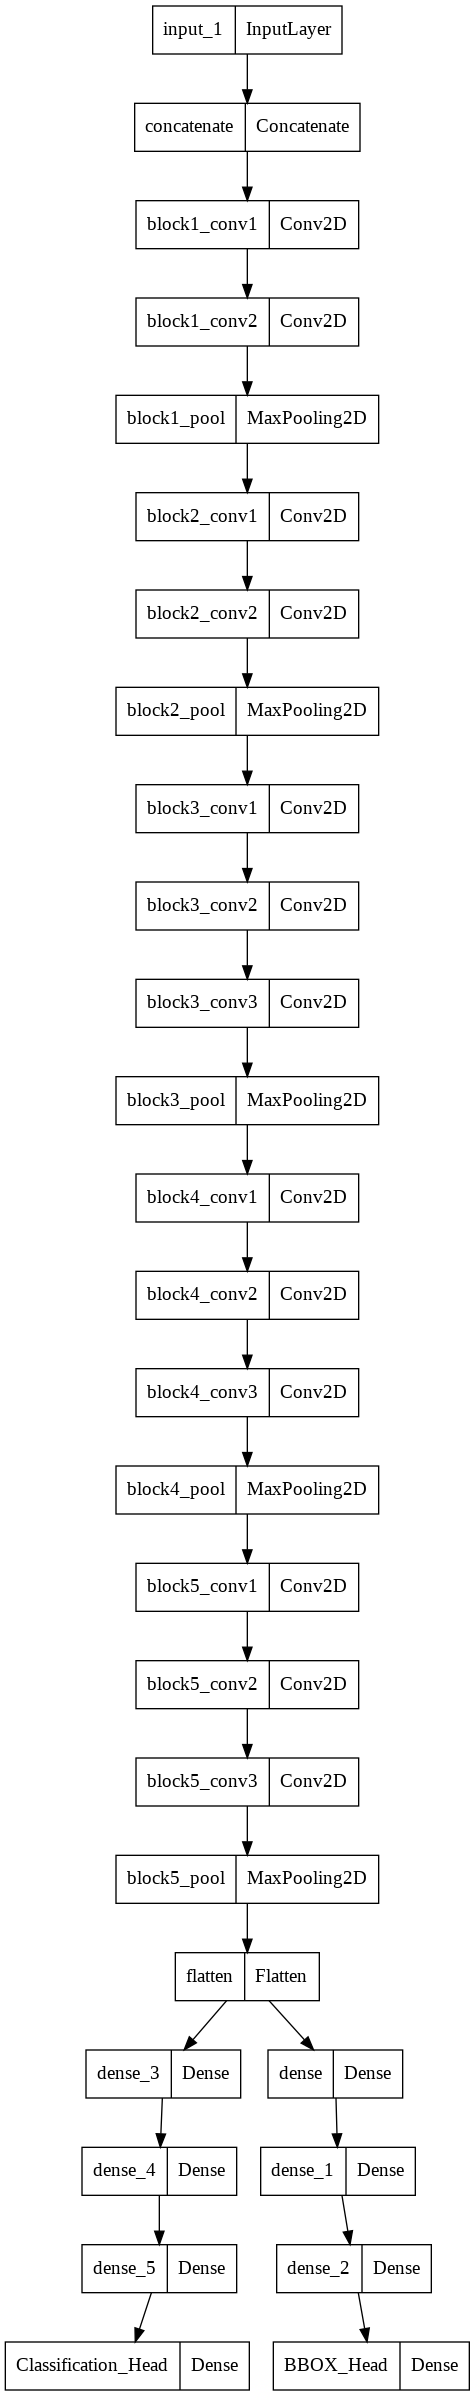

In [75]:
from keras.utils.vis_utils import plot_model
import tensorflow as tf
tf.keras.utils.plot_model(
model, to_file='model.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [76]:
data_split = train_test_split(data, target_label, bbox_coords, img_paths,	test_size=0.30, random_state=12)

(trainImages, testImages) = data_split[:2]
(trainLabels, testLabels) = data_split[2:4]
(trainBBoxes, testBBoxes) = data_split[4:6]
(trainPaths, testPaths) = data_split[6:]

In [77]:
print("[INFO] Training the Model...")

History = model.fit(
    trainImages, [trainLabels, trainBBoxes],
	validation_data=(testImages, [testLabels,testBBoxes]),
	batch_size=32,
	epochs=20,
	verbose=1)


[INFO] Training the Model...
Epoch 1/20
219/219 [==============================] - 115s 437ms/step - loss: nan - Classification_Head_loss: nan - BBOX_Head_loss: 0.0307 - Classification_Head_accuracy: 0.6706 - BBOX_Head_accuracy: 0.3421 - val_loss: nan - val_Classification_Head_loss: nan - val_BBOX_Head_loss: 0.0279 - val_Classification_Head_accuracy: 0.6807 - val_BBOX_Head_accuracy: 0.4927
Epoch 2/20
219/219 [==============================] - 92s 419ms/step - loss: nan - Classification_Head_loss: nan - BBOX_Head_loss: 0.0278 - Classification_Head_accuracy: 0.6706 - BBOX_Head_accuracy: 0.4440 - val_loss: nan - val_Classification_Head_loss: nan - val_BBOX_Head_loss: 0.0266 - val_Classification_Head_accuracy: 0.6807 - val_BBOX_Head_accuracy: 0.3587
Epoch 3/20
219/219 [==============================] - 91s 417ms/step - loss: nan - Classification_Head_loss: nan - BBOX_Head_loss: 0.0266 - Classification_Head_accuracy: 0.6706 - BBOX_Head_accuracy: 0.3849 - val_loss: nan - val_Classification_H

In [78]:
# Save model
print("[INFO] Saving Object Detector Model...")
model.save("/content/drive/MyDrive/VGGMOD", save_format="h5")#Use your drive path

[INFO] Saving Object Detector Model...


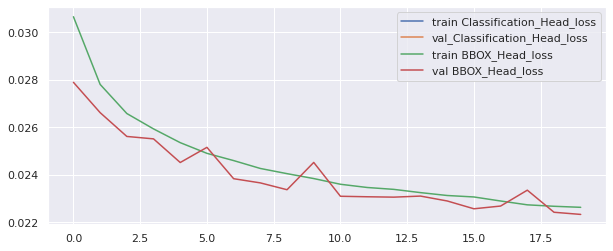

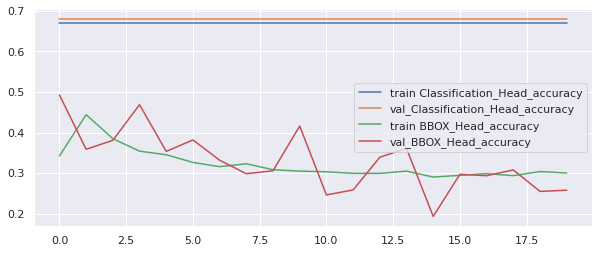

<Figure size 720x288 with 0 Axes>

In [79]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(History.history['Classification_Head_loss'], label='train Classification_Head_loss')
plt.plot(History.history['val_Classification_Head_loss'], label='val_Classification_Head_loss')
plt.plot(History.history['BBOX_Head_loss'], label='train BBOX_Head_loss')
plt.plot(History.history['val_BBOX_Head_loss'], label='val BBOX_Head_loss')

plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(History.history['Classification_Head_accuracy'], label='train Classification_Head_accuracy')
plt.plot(History.history['val_Classification_Head_accuracy'], label='val_Classification_Head_accuracy')
plt.plot(History.history['BBOX_Head_accuracy'], label='train BBOX_Head_accuracy')
plt.plot(History.history['val_BBOX_Head_accuracy'], label='val_BBOX_Head_accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

**Without a Pre-Trained Model**

In [80]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D,MaxPool2D

In [81]:
# Part 2 - Building the CNN
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[224, 224, 1]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())


x0 = cnn.layers[-1].output



# New FC layers for Regression
bboxHead = Dense(128, activation="relu")(x0)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="BBOX_Head")(bboxHead)

# New FC layers for Classification
classHead = Dense(512, activation="relu")(x0)
classHead = Dense(256, activation="relu")(classHead)
classHead = Dense(128, activation="relu")(classHead)
classHead = Dense(1, activation="sigmoid", name="Classification_Head")(classHead)


# # Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# # Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
# ## For Binary Classification
cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
='linear'))

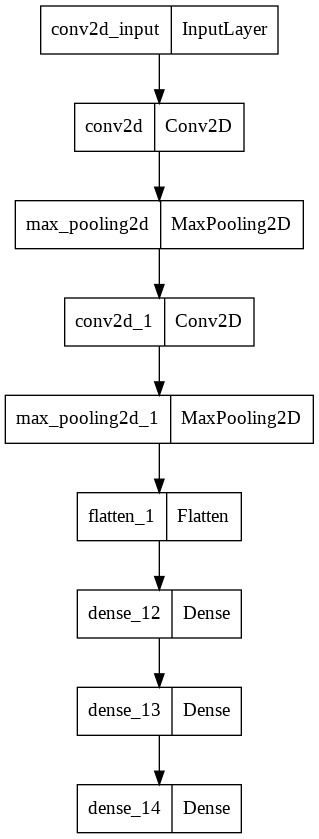

In [82]:
tf.keras.utils.plot_model(
cnn, to_file='cnn.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [83]:
#cnn.compile(optimizer = 'adam', loss = 'squared_hinge', metrics = ['accuracy'])
cnn.compile(loss=losses, optimizer=opt, loss_weights= loss_weights, metrics=["accuracy"])


In [84]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               3

In [85]:
model = Model(inputs=cnn.input, outputs=(classHead, bboxHead))

In [86]:
model.compile(loss=losses, optimizer=opt, loss_weights= loss_weights, metrics=["accuracy"])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  320         ['conv2d_input[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 32)   0           ['conv2d[0][0]']                 
                                                                                            

In [87]:
print("[INFO] Training the Model...")

History = model.fit(
    trainImages, [trainLabels, trainBBoxes],
	validation_data=(testImages, [testLabels,testBBoxes]),
	batch_size=32,
	epochs=20,
	verbose=1)

[INFO] Training the Model...
Epoch 1/20
219/219 [==============================] - 13s 47ms/step - loss: nan - Classification_Head_loss: nan - BBOX_Head_loss: nan - Classification_Head_accuracy: 0.6697 - BBOX_Head_accuracy: 0.7717 - val_loss: nan - val_Classification_Head_loss: nan - val_BBOX_Head_loss: nan - val_Classification_Head_accuracy: 0.6807 - val_BBOX_Head_accuracy: 0.8067
Epoch 2/20
219/219 [==============================] - 9s 41ms/step - loss: nan - Classification_Head_loss: nan - BBOX_Head_loss: nan - Classification_Head_accuracy: 0.6706 - BBOX_Head_accuracy: 0.8014 - val_loss: nan - val_Classification_Head_loss: nan - val_BBOX_Head_loss: nan - val_Classification_Head_accuracy: 0.6807 - val_BBOX_Head_accuracy: 0.8067
Epoch 3/20
219/219 [==============================] - 9s 40ms/step - loss: nan - Classification_Head_loss: nan - BBOX_Head_loss: nan - Classification_Head_accuracy: 0.6706 - BBOX_Head_accuracy: 0.8014 - val_loss: nan - val_Classification_Head_loss: nan - val_B

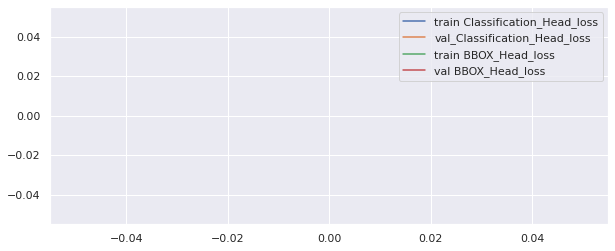

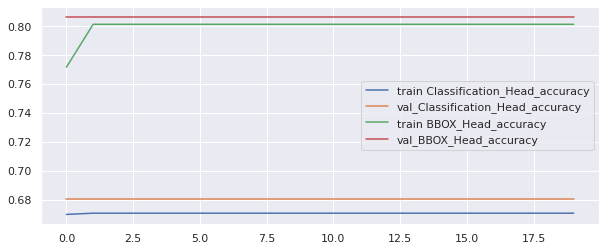

<Figure size 720x288 with 0 Axes>

In [88]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(History.history['Classification_Head_loss'], label='train Classification_Head_loss')
plt.plot(History.history['val_Classification_Head_loss'], label='val_Classification_Head_loss')
plt.plot(History.history['BBOX_Head_loss'], label='train BBOX_Head_loss')
plt.plot(History.history['val_BBOX_Head_loss'], label='val BBOX_Head_loss')

plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(History.history['Classification_Head_accuracy'], label='train Classification_Head_accuracy')
plt.plot(History.history['val_Classification_Head_accuracy'], label='val_Classification_Head_accuracy')
plt.plot(History.history['BBOX_Head_accuracy'], label='train BBOX_Head_accuracy')
plt.plot(History.history['val_BBOX_Head_accuracy'], label='val_BBOX_Head_accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

**Model testing**

In [89]:
y_pred= model.predict(testImages[testLabels])

In [90]:
y_pred[0]

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [91]:
y_pred[1]

array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]], dtype=float32)

In [104]:
History.history

{'BBOX_Head_accuracy': [0.7717142701148987,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607,
  0.8014285564422607],
 'BBOX_Head_loss': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 'Classification_Head_accuracy': [0.6697142720222473,
  0.6705714464187622,
  0.6705714464187622,
  0.6705714464187622,
  0.6705714464187622,
  0.6705714464187622,
  0.6705714464187622,
  0.6705714464187622,
  0.6705714464187622,
  0.6705714464187622,
  0.6705714464187622,
  0.6705714464187622,
  0.6705714464187622,
  0.6705714464187622,
  0.6705714464187622,
  0.670571446418

**END**